### --- Use GPU Configuration to achieve better latency ---

In [1]:
import tensorflow
import keras

In [2]:
import numpy as np
import torchvision.transforms as T
import torchvision
import torch
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import pickle
from numpy.linalg import norm
from tqdm import tqdm
import glob
import pandas as pd

In [3]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from keras.models import load_model

In [4]:
from skimage import io

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# display images
from torchvision import utils

# utils
from torchsummary import summary
import time
import copy

In [6]:
from PIL import ImageFile
from PIL import Image 
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 1000000000 

In [7]:
df = pd.read_csv("data.csv")
df['filename'] = df.apply(lambda row: str(row['item_id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(3)

,item_id,item_name,category_id,category_name,image_url,filename
0,88903226,Commercial Coffee Vending Machine,3912,Coffee Vending Machines,http://4.imimg.com/data4/SC/HQ/MY-31037626/com...,88903226.jpg
1,121758398,Plastic Chair,6042,Plastic Chairs,http://4.imimg.com/data4/LC/HI/ANDROID-1123974...,121758398.jpg
2,50841121,Sunglasses,1388,Sun Glasses,http://3.imimg.com/data3/HT/VV/MY-3433590/sung...,50841121.jpg


## FastRCNN for Object Detection

In [8]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

C:\Users\Ruchi Rani\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ruchi Rani\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
def detailed_get_prediction(img_path, threshold):
    img = Image.open(img_path) 
    transform = T.Compose([T.ToTensor()]) 
    img = transform(img) 
    pred = model([img])
    print('pred\n')
    print(pred)
    
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
    print("\n original pred_boxes\n")
    print(pred_boxes)
    
    pred_score = list(pred[0]['scores'].detach().numpy())
    print("\n orignal score\n")
    print(pred_score)
    
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
    pred_boxes = pred_boxes[:pred_t+1]
    print(pred_t)
    print(pred_boxes)
    return pred_boxes

In [10]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path) 
    transform = T.Compose([T.ToTensor()])
    img = transform(img) 
    pred = model([img])
    
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    
    pred_score = list(pred[0]['scores'].detach().numpy())
    
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    
    pred_boxes = pred_boxes[:pred_t+1]
    return pred_boxes

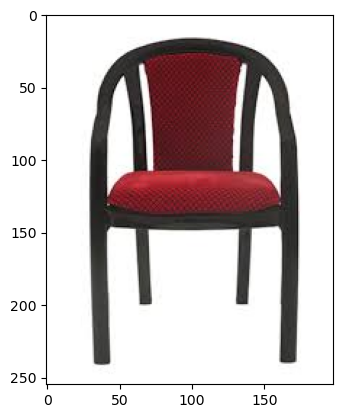

In [11]:
import urllib

url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSyKswJ5KudNgMacgxoqSDHYtrQoL9dfSeaMQ&usqp=CAU"

img_path = urllib.request.urlretrieve(url, 'sample/image.jpg')
img_path = Image.open("sample/image.jpg")
plt.imshow(img_path)

In [12]:
img_path = "sample/image.jpg"
boxes = get_prediction(img_path, threshold=0.1)

In [13]:
img = cv2.imread(img_path)
img.shape

(255, 198, 3)

In [14]:
img = cv2.imread(img_path) # Read image with cv2
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB

text_size=1
text_th=2

image_number = 0

area = []

for i in range(len(boxes)):
    
    start_point = (int(boxes[i][0][0]), int(boxes[i][0][1]))
    end_point = (int(boxes[i][1][0]), int(boxes[i][1][1]))
    
    print("start_point : ", start_point)
    print("end_point : ", end_point)
    
    a1 = int((int(boxes[i][1][0]) - int(boxes[i][0][0])) * (int(boxes[i][1][1]) - int(boxes[i][0][1])))
    area.append(a1)
    
    roi = img[int(boxes[i][0][1]): int(boxes[i][1][1]), int(boxes[i][0][0]):int(boxes[i][1][0])]
    rgbImg = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    cv2.imwrite("./output/" + "cropped_{}.jpg".format(image_number), rgbImg) 
    image_number += 1

start_point :  (31, 16)
end_point :  (178, 232)
start_point :  (36, 21)
end_point :  (166, 138)
start_point :  (42, 104)
end_point :  (163, 138)


In [15]:
ma = max(area)
im = area.index(ma)
print(im)

0


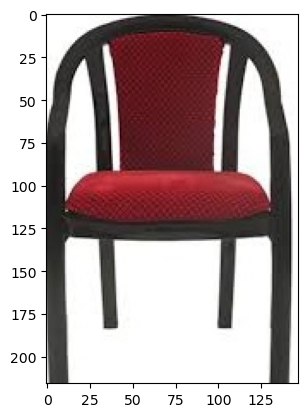

In [16]:
img_path = Image.open("output/cropped_" + str(im) + ".jpg")
plt.imshow(img_path)

## Category prediction

1) Train any suitable model (like  AlexNet, VGGNet, GoogLeNet (Inception), ResNet, and DenseNet) on your image_dataset. I used DenseNet121 for my dataset. Accuarcy = 99%

2) Predict the category

In [19]:
from keras.models import load_model

file = []
imm = "cropped_" + str(im) + ".jpg"
file.append(os.path.join('output',imm))

for imm in tqdm(file):
    model = load_model('model/DenseNet121_model.h5')
    test_image = tf.keras.utils.load_img(imm, target_size=(224,224))
    test_image = np.array(test_image)
    test_image = test_image / 255.0
    test_image = test_image.reshape(1, 224, 224, 3)
    #test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    
    val = np.argmax(result)
    
    #my_dict = train_generator.class_indices
    my_dict = {'Coffee Vending Machines': 0,  
               'Plastic Chairs': 1, 
               'Sun Glasses': 2}
    
    key_list = list(my_dict.keys()) 
    val_list = list(my_dict.values()) 
    print("\n Category: ", key_list[val]) 

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.77s/it]


 Category:  Plastic Chairs


## Category-Wise Feature Extraction = Sample Code

In [ ]:
model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.trainable = False

model = tensorflow.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])

print(model.summary())

In [ ]:
def extract_features(img_path,model):
    img = image.load_img(img_path,target_size=(224,224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)

    return normalized_result

In [ ]:
# Replace "-- category-1 --" with the categories name. For Eg:- Plastic chairs, Fashion clothes, sunglasses, etc.
# Extract their features and dump each category's features in different pickle file.

filenames = []

for file in os.listdir('-- category-1 images --'):
    filenames.append(os.path.join('-- category-1 images --',file))   

feature_list = []

for file in tqdm(filenames):
    feature_list.append(extract_features(file,model))
    
pickle.dump(feature_list,open('./files/embeddings_-- category-1 --.pkl','wb'))
pickle.dump(filenames,open('./files/filenames_-- category-1 --.pkl','wb'))

## PCA + AnnoyIndex = Sample Code

In [ ]:
# Compress each category and dump each category in different joblib file

In [ ]:
from sklearn.decomposition import PCA
import joblib

num_images = len(filenames)
num_features_per_image = len(feature_list[0])

num_images, num_features_per_image

In [ ]:
num_feature_dimensions = 1024
num_feature_dimensions = min(num_images, num_feature_dimensions,
                             len(feature_list[0]))

In [ ]:
pca = PCA(n_components=num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)
feature_list_compressed = feature_list_compressed.tolist()
#print(pca.explained_variance_ratio_[0:20])
joblib.dump(pca, "./pca/pca_-- category-1 --.joblib")

In [ ]:
# use compressed feature, create index and dump each category's index in different ann file

In [ ]:
import annoy
from annoy import AnnoyIndex
import time

In [ ]:
annoy_training_time = []
annoy_test_time = []
annoy_trees = [
    1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300
]
for num_trees in annoy_trees:
    t = AnnoyIndex(num_feature_dimensions, "angular")  # Length of item vector that will be indexed
    for i in range(num_images):
        feature = feature_list_compressed[i]
        t.add_item(i, feature)
    start_time = time.time()
    t.build(num_trees) 
    t.save("./annoy/index_-- category-1 --.ann")
    end_time = time.time()
    annoy_training_time.append(end_time - start_time)
    annoy_test_time.append(end_time - start_time)
    print("For number of trees = ", num_trees, ",\tTime to train = ",
          annoy_training_time[-1], ",\tTime to test = ", annoy_test_time[-1])

## TEST THE MODEL

In [20]:
from sklearn.decomposition import PCA
import joblib
import annoy
from annoy import AnnoyIndex

In [21]:
feature_list = np.array(pickle.load(open('files/embeddings_' + str(key_list[val]) + '.pkl','rb')))
filenames = pickle.load(open('files/filenames_' + str(key_list[val]) + '.pkl','rb'))

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 859ms/step
[1241, 9273, 3805, 4736, 15290, 13074, 237, 12534, 2465, 7097, 24762, 3939, 23233, 20792, 14679, 27903, 4963, 5296, 14212, 22373, 28419, 3541, 27466, 22770, 27134] [0.704495370388031, 0.7370228171348572, 0.7869216203689575, 0.7942883372306824, 0.8049014210700989, 0.8262634873390198, 0.8383000493049622, 0.8391259908676147, 0.8396327495574951, 0.8450689911842346, 0.8478983640670776, 0.8741644024848938, 0.8794606328010559, 0.8828216195106506, 0.8857285380363464, 0.8950360417366028, 0.9019515514373779, 0.9019790291786194, 0.9052658677101135, 0.9052658677101135, 0.9052658677101135, 0.9080442190170288, 0.9131416082382202, 0.9246953129768372, 0.9328452348709106]


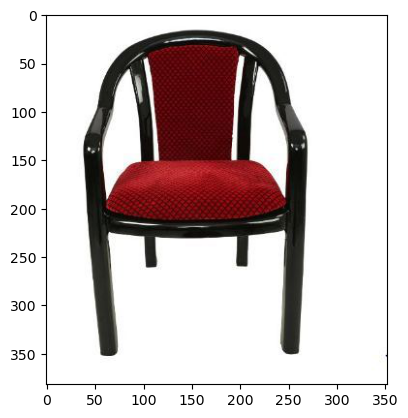

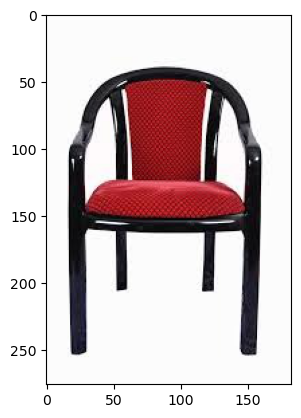

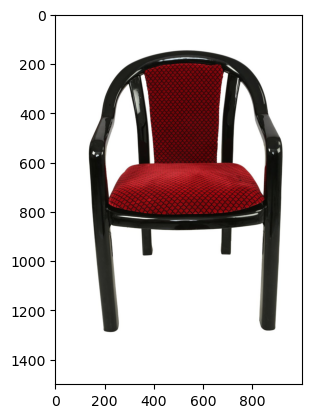

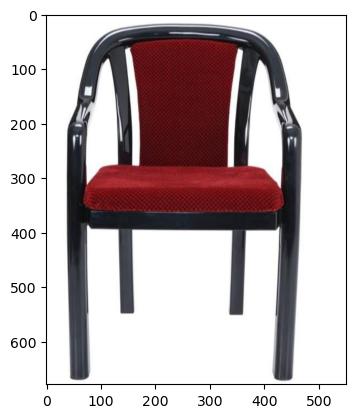

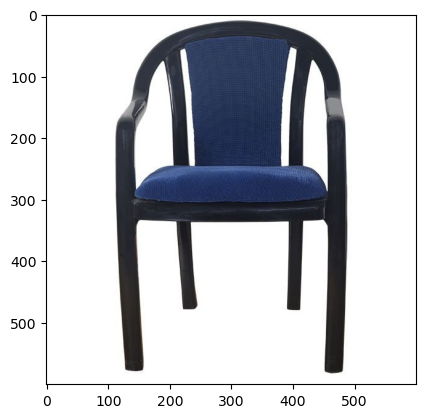

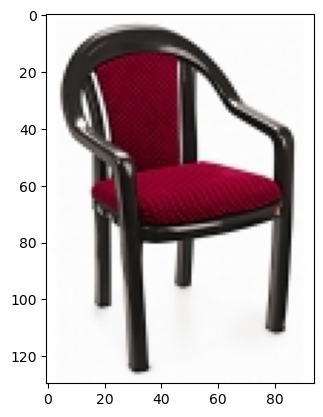

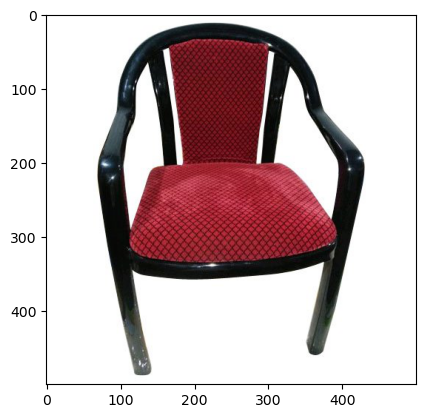

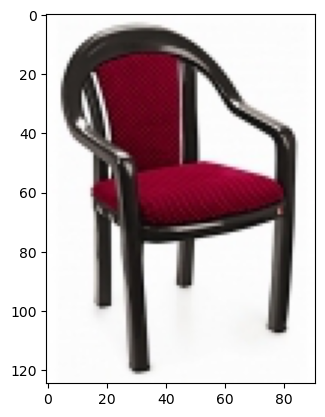

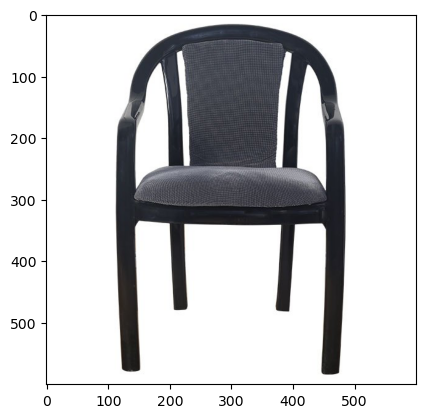

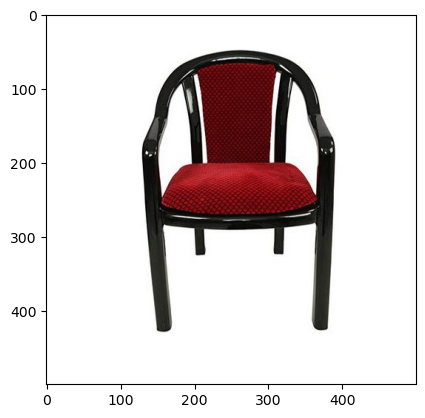

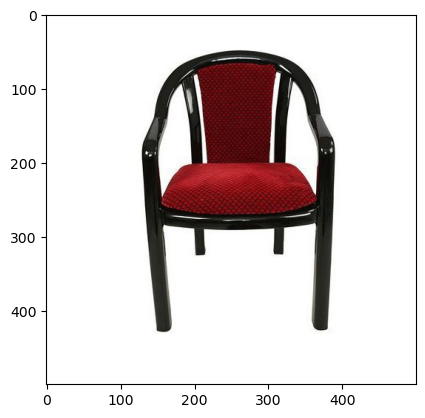

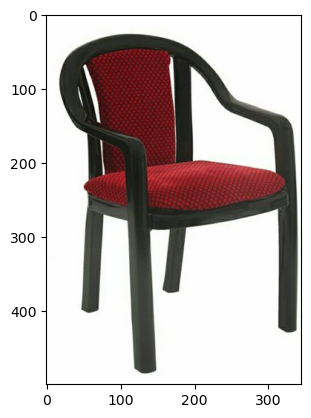

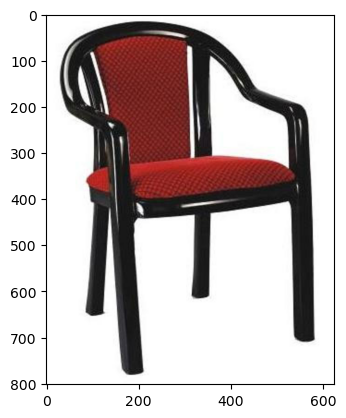

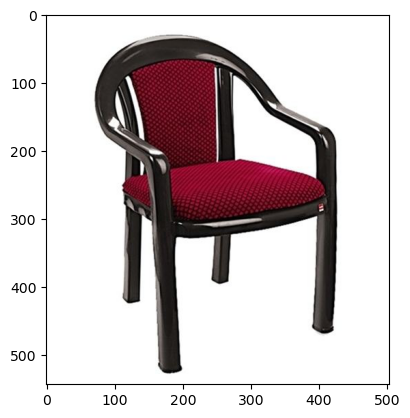

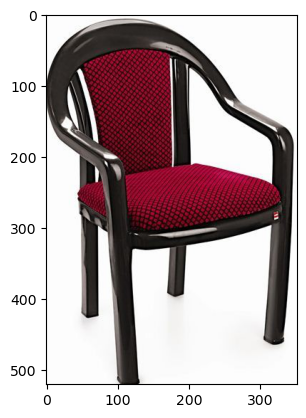

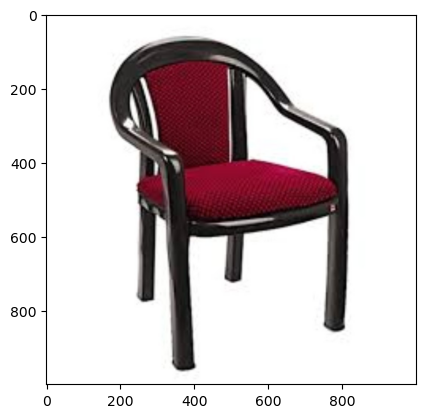

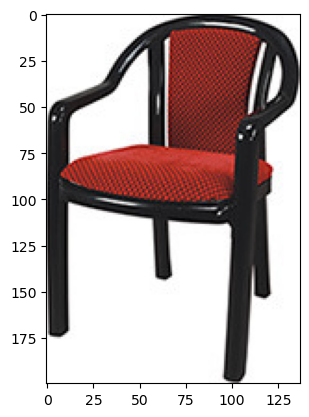

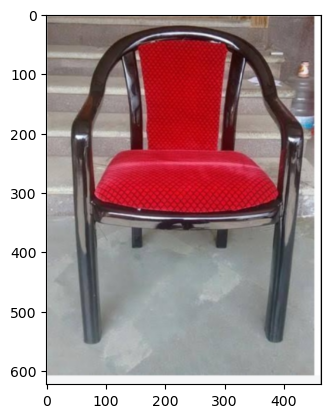

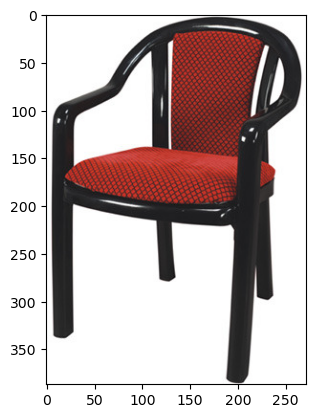

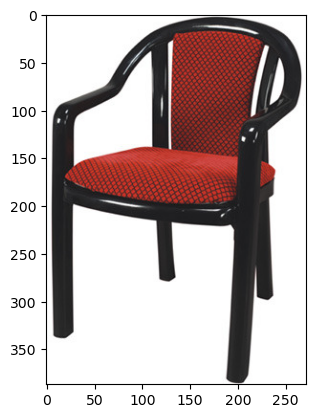

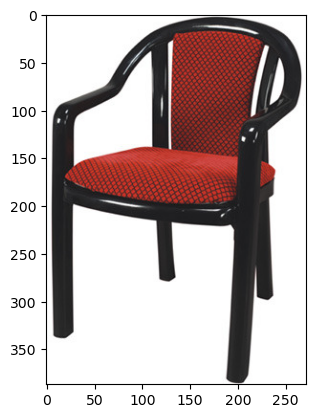

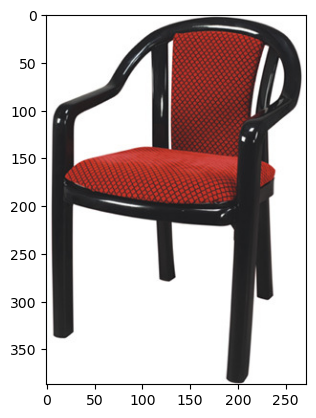

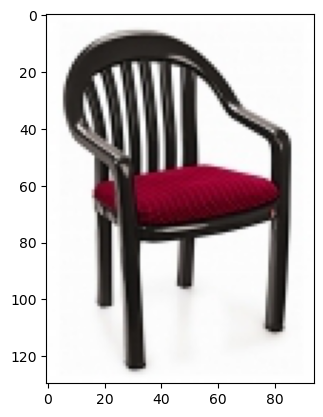

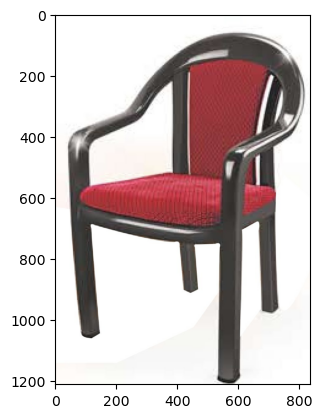

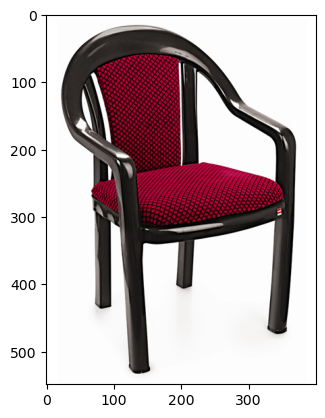

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.39s/it]


In [22]:
model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.trainable = False

model = tensorflow.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])

def extract_features(img_path,model):
    img = load_img(img_path,target_size=(224,224))
    img_array = img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result).reshape(-1,1) 
    
    pca = joblib.load("pca/pca_" + str(key_list[val]) + ".joblib")
    components = pca.transform(normalized_result)[0]

    t = AnnoyIndex(components.shape[0], "angular")
    t.load("index/index_" + str(key_list[val]) + ".ann")
    
    indices, distance = t.get_nns_by_vector(components, 25, include_distances=True)
    print(indices, distance)

    for j in indices[0:25]:
        try:
            temp_img = plt.imread(filenames[j])
            #temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
            plt.imshow(temp_img)
            plt.show()
        except:
            continue

file = []

imm = "cropped_" + str(im) + ".jpg"
file.append(os.path.join('output',imm))

for imm in tqdm(file):
    extract_features(imm,model)
    
removing_files = glob.glob('output/*.jpg')
for i in removing_files:
    os.remove(i)

Yahoo.. Great Work, guys :D 

This code is a starting point to create your very own visual search tool. However, I want to remind you all to be careful while training your dataset, especially when dealing with multiclass data. Remember, accuracy is essential, so take your time and make sure to get it right. 🌟

Thanks for following along, and keep up the great learning! Have an amazing time exploring and creating UwU